In [3]:
pip install wfdb

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ------------------------------- -------- 0.8/1.0 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import wfdb
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pywt
from tqdm import tqdm  # 导入 tqdm
from scipy.signal import find_peaks, medfilt
from numpy import trapz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [17]:
def read_bindata(file_path):
    """读取.bin文件并返回ECG数据"""
    with open(file_path, 'rb') as fidin:
        # 跳过文件头部的非数据部分，根据MATLAB代码，数据从第529个字节开始
        fidin.seek(528)
        # 读取数据部分
        data_raw = fidin.read()
    
    # 根据MATLAB代码，每个数据点由两个字节组成
    data = np.frombuffer(data_raw, dtype=np.uint16)
    
    # 截取前500000个数据点
    data_500000 = data[:500000]
    
    return data_500000

def process_ecg_data(base_path, output_file, label):
    """处理ECG数据并保存到一个.pkl文件中，同时添加标签"""
    all_data = {}
    # 遍历所有被试文件夹
    for subject in range(1, 90):  # 被试编号从001到089
        subject_folder = f"{subject:03d}"  # 格式化编号为三位数，例如001
        subject_path = os.path.join(base_path, subject_folder)
        
        # 检查被试文件夹是否存在
        if not os.path.isdir(subject_path):
            print(f"被试文件夹 {subject_folder} 不存在，跳过。")
            continue
        
        # 获取.bin文件路径
        bin_files = [f for f in os.listdir(subject_path) if f.endswith('.bin')]
        if not bin_files:
            print(f"被试 {subject_folder} 中没有.bin文件，跳过。")
            continue
        
        bin_file_path = os.path.join(subject_path, bin_files[0])
        
        # 读取并处理数据
        ecg_data = read_bindata(bin_file_path)
        
        # 保存到字典中，并添加标签
        all_data[subject_folder] = {'data': ecg_data, 'label': label}
    
    # 将所有数据保存到.pkl文件
    with open(output_file, 'wb') as f:
        pickle.dump(all_data, f)
    
    print(f"所有数据已保存到 {output_file}")

# 设置基础路径和输出文件名
base_path_positive = 'Y:\\生物医学信号处理\\project\\vn5nknh3mn-2\\all_data\\ECG_experiment\\positive'
output_file_positive = 'ecg_data_500000_positive1.pkl'
process_ecg_data(base_path_positive, output_file_positive, label=1)

base_path_negative = 'Y:\\生物医学信号处理\\project\\vn5nknh3mn-2\\all_data\\ECG_experiment\\negative'
output_file_negative = 'ecg_data_500000_negative1.pkl'
process_ecg_data(base_path_negative, output_file_negative, label=0)

被试文件夹 002 不存在，跳过。
被试文件夹 004 不存在，跳过。
被试文件夹 005 不存在，跳过。
被试文件夹 006 不存在，跳过。
被试文件夹 007 不存在，跳过。
被试文件夹 008 不存在，跳过。
被试文件夹 009 不存在，跳过。
被试文件夹 010 不存在，跳过。
被试文件夹 012 不存在，跳过。
被试文件夹 013 不存在，跳过。
被试文件夹 014 不存在，跳过。
被试文件夹 015 不存在，跳过。
被试文件夹 016 不存在，跳过。
被试文件夹 018 不存在，跳过。
被试文件夹 019 不存在，跳过。
被试文件夹 021 不存在，跳过。
被试文件夹 022 不存在，跳过。
被试文件夹 023 不存在，跳过。
被试文件夹 024 不存在，跳过。
被试文件夹 025 不存在，跳过。
被试文件夹 026 不存在，跳过。
被试文件夹 030 不存在，跳过。
被试文件夹 031 不存在，跳过。
被试文件夹 033 不存在，跳过。
被试文件夹 034 不存在，跳过。
被试文件夹 037 不存在，跳过。
被试文件夹 038 不存在，跳过。
被试文件夹 039 不存在，跳过。
被试文件夹 040 不存在，跳过。
被试文件夹 041 不存在，跳过。
被试文件夹 042 不存在，跳过。
被试文件夹 044 不存在，跳过。
被试文件夹 045 不存在，跳过。
被试文件夹 047 不存在，跳过。
被试文件夹 048 不存在，跳过。
被试文件夹 049 不存在，跳过。
被试文件夹 050 不存在，跳过。
被试文件夹 053 不存在，跳过。
被试文件夹 054 不存在，跳过。
被试文件夹 055 不存在，跳过。
被试文件夹 056 不存在，跳过。
被试文件夹 058 不存在，跳过。
被试文件夹 060 不存在，跳过。
被试文件夹 061 不存在，跳过。
被试文件夹 062 不存在，跳过。
被试文件夹 063 不存在，跳过。
被试文件夹 065 不存在，跳过。
被试文件夹 066 不存在，跳过。
被试文件夹 067 不存在，跳过。
被试文件夹 068 不存在，跳过。
被试文件夹 069 不存在，跳过。
被试文件夹 071 不存在，跳过。
被试文件夹 072 不存在，跳过。
被试文件夹 074 不存在，跳过。
被试文件夹 075 不存在，跳过。
被试文件夹 076 

In [19]:
    #重启内核后加载数据
    import pickle
    
    # 加载 P_data
    with open('ecg_data_500000_positive1.pkl', 'rb') as f:
        P_data = pickle.load(f)
    
    # 加载 N_data
    with open('ecg_data_500000_negative1.pkl', 'rb') as f:
        N_data = pickle.load(f)
    
    print(f"P_data 中的 DataFrame 数量: {len(P_data)}")
    print(f"N_data 中的 DataFrame 数量: {len(N_data)}")

P_data 中的 DataFrame 数量: 25
N_data 中的 DataFrame 数量: 57


In [5]:
import numpy as np
from scipy.signal import savgol_filter

# 初始化用于保存滤波后的数据的列表
P_data_SG = []
N_data_SG = []

# 遍历所有 P_data 进行滤波
for subject, data_dict in P_data.items():
    # 获取实际的数据
    data = data_dict['data']
    # 对 y_values 进行 Savitzky-Golay 滤波，窗口长度为11，多项式度数为3
    filtered_y_values = savgol_filter(data, window_length=11, polyorder=3)
    # 将滤波后的结果存储在列表中
    P_data_SG.append(filtered_y_values)

# 遍历所有 N_data 进行滤波
for subject, data_dict in N_data.items():
    # 获取实际的数据
    data = data_dict['data']
    # 对 y_values 进行 Savitzky-Golay 滤波，窗口长度为11，多项式度数为3
    filtered_y_values = savgol_filter(data, window_length=11, polyorder=3)
    # 将滤波后的结果存储在列表中
    N_data_SG.append(filtered_y_values)
print('滤波成功1')
# 现在 P_data_SG 和 N_data_SG 中保存了滤波后的数值数组

滤波成功1


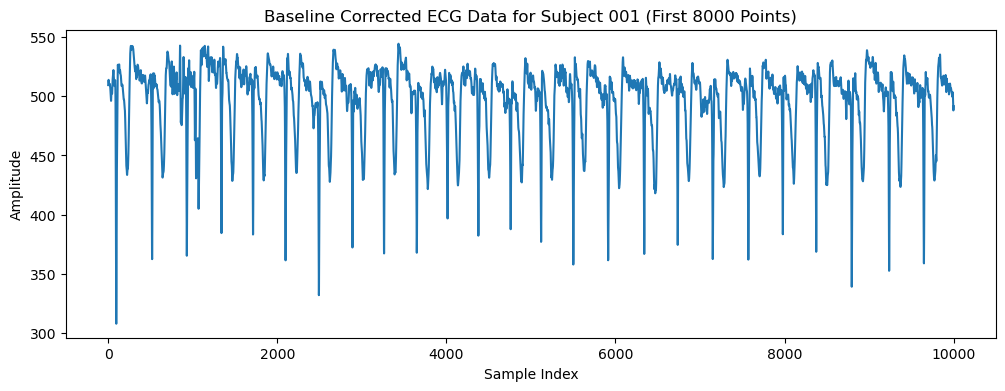

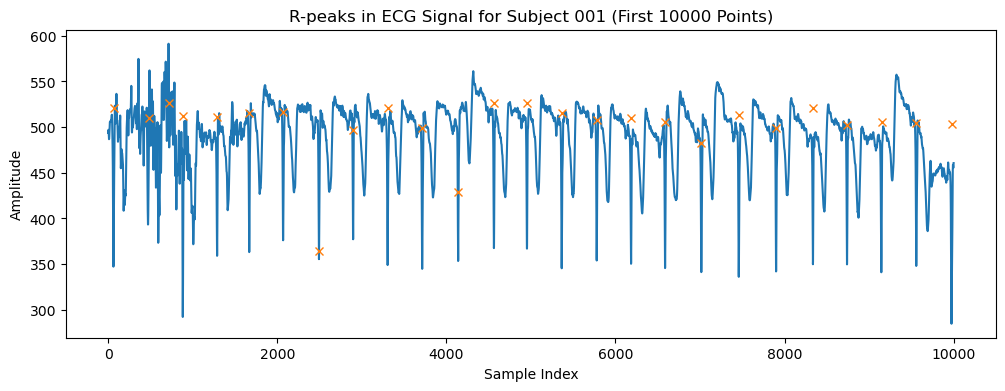

Heart Rate: 81.03 bpm
Heart Rate Variability: 0.12 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import find_peaks

# 假设 P_data_SG 和 N_data_SG 已经是滤波后的数据列表
# P_data_SG[0] 和 N_data_SG[0] 分别是正类和负类1号被试的滤波后数据

# 绘制1号被试滤波后的数据（前8000个点）
def plot_ecg(data, title="ECG Data"):
    plt.figure(figsize=(12, 4))
    plt.plot(data[0:10000])  # 修改为只绘制前8000个点
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

# 基线漂移校正函数
def correct_baseline(data, wavelet='db4', level=1):
    # 使用小波变换进行基线估计
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # 将最后一个系数（近似系数，即基线）设置为0
    coeffs[-1] *= 0
    # 重构信号
    corrected_data = pywt.waverec(coeffs, wavelet)
    # 确保校正后的数据长度与原始数据相同
    if len(corrected_data) > len(data):
        corrected_data = corrected_data[:len(data)]
    return corrected_data

# 对1号被试的ECG数据进行基线校正
P_data_corrected = correct_baseline(P_data_SG[3])

# 对1号被试基线校正后的数据进行绘图（前8000个点）
plot_ecg(P_data_corrected, "Baseline Corrected ECG Data for Subject 001 (First 8000 Points)")

# Pan-Tompkins算法检测R波
def detect_r_peaks(ecg_signal, sampling_rate=512):
    # 使用Pan-Tompkins算法参数
    diff_signal = np.diff(ecg_signal)
    squared_signal = diff_signal ** 2
    integrated_signal = np.convolve(squared_signal, np.ones(30), mode='same')
    peaks, _ = find_peaks(integrated_signal, distance=sampling_rate * 0.3, height=0.1 * np.max(integrated_signal))
    return peaks

# 检测1号被试的R波
r_peaks = detect_r_peaks(P_data_corrected[10000:20000])
sampling_rate=512

# 绘制1号被试的前10000个数据点，并标出R波峰值
plt.figure(figsize=(12, 4))
plt.plot(P_data_corrected[10000:20000])
plt.plot(r_peaks, P_data_corrected[r_peaks], "x")
plt.title("R-peaks in ECG Signal for Subject 001 (First 10000 Points)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

# 计算心率和心率变异性指标
rr_intervals = np.diff(r_peaks) / sampling_rate  # RR间期，单位为秒
heart_rate = 60 / rr_intervals  # 心率，单位为bpm
heart_rate_variability = np.std(rr_intervals)  # 心率变异性

print(f"Heart Rate: {np.mean(heart_rate):.2f} bpm")
print(f"Heart Rate Variability: {heart_rate_variability:.2f} seconds")

In [7]:
import numpy as np
import pickle
import pywt
from scipy.signal import find_peaks, savgol_filter

# 假设 P_data_SG 和 N_data_SG 已经是滤波后的数据列表
# P_data_SG[0] 和 N_data_SG[0] 分别是正类和负类1号被试的滤波后数据

# 基线漂移校正函数
def correct_baseline(data, wavelet='db4', level=1):
    # 使用小波变换进行基线估计
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # 将最后一个系数（近似系数，即基线）设置为0
    coeffs[-1] *= 0
    # 重构信号
    corrected_data = pywt.waverec(coeffs, wavelet)
    # 确保校正后的数据长度与原始数据相同
    if len(corrected_data) > len(data):
        corrected_data = corrected_data[:len(data)]
    return corrected_data

# Pan-Tompkins算法检测R波
def detect_r_peaks(ecg_signal, sampling_rate=512):
    # 使用Pan-Tompkins算法参数
    diff_signal = np.diff(ecg_signal)
    squared_signal = diff_signal ** 2
    integrated_signal = np.convolve(squared_signal, np.ones(30), mode='same')
    peaks, _ = find_peaks(integrated_signal, distance=sampling_rate * 0.3, height=0.1 * np.max(integrated_signal))
    return peaks

# 计算心率和心率变异性指标
def calculate_hr_hrv(r_peaks, sampling_rate=512):
    rr_intervals = np.diff(r_peaks) / sampling_rate  # RR间期，单位为秒
    heart_rate = 60 / rr_intervals  # 心率，单位为bpm
    heart_rate_variability = np.std(rr_intervals)  # 心率变异性
    return np.mean(heart_rate), heart_rate_variability

# 初始化特征矩阵
features_matrix = []

# 处理所有被试的数据
for subject, data_dict in P_data.items():
    # 获取实际的数据
    data = data_dict['data']
    # 基线校正
    corrected_data = correct_baseline(data)
    # R波检测
    r_peaks = detect_r_peaks(corrected_data)
    # 心率和心率变异性计算
    heart_rate, heart_rate_variability = calculate_hr_hrv(r_peaks)
    # 打印结果
    print(f"Subject {subject}: Heart Rate: {heart_rate:.2f} bpm, Heart Rate Variability: {heart_rate_variability:.2f} seconds")
    # 添加到特征矩阵
    features_matrix.append([heart_rate, heart_rate_variability])

for subject, data_dict in N_data.items():
    # 获取实际的数据
    data = data_dict['data']
    # 基线校正
    corrected_data = correct_baseline(data)
    # R波检测
    r_peaks = detect_r_peaks(corrected_data)
    # 心率和心率变异性计算
    heart_rate, heart_rate_variability = calculate_hr_hrv(r_peaks)
    # 打印结果
    print(f"Subject {subject}: Heart Rate: {heart_rate:.2f} bpm, Heart Rate Variability: {heart_rate_variability:.2f} seconds")
    # 添加到特征矩阵
    features_matrix.append([heart_rate, heart_rate_variability])

# 将特征矩阵转换为NumPy数组
features_matrix = np.array(features_matrix)

# 保存特征矩阵到文件
with open('features_matrix.pkl', 'wb') as f:
    pickle.dump(features_matrix, f)

print(f"特征矩阵已保存到 features_matrix.pkl")

Subject 001: Heart Rate: 85.10 bpm, Heart Rate Variability: 0.06 seconds
Subject 003: Heart Rate: 76.54 bpm, Heart Rate Variability: 0.11 seconds
Subject 011: Heart Rate: 78.36 bpm, Heart Rate Variability: 0.08 seconds
Subject 017: Heart Rate: 73.25 bpm, Heart Rate Variability: 0.07 seconds
Subject 020: Heart Rate: 86.64 bpm, Heart Rate Variability: 0.13 seconds
Subject 027: Heart Rate: 31.43 bpm, Heart Rate Variability: 164.84 seconds
Subject 028: Heart Rate: 73.05 bpm, Heart Rate Variability: 0.11 seconds
Subject 029: Heart Rate: 88.27 bpm, Heart Rate Variability: 0.46 seconds
Subject 032: Heart Rate: 83.48 bpm, Heart Rate Variability: 0.17 seconds
Subject 035: Heart Rate: 96.27 bpm, Heart Rate Variability: 0.34 seconds
Subject 036: Heart Rate: 82.77 bpm, Heart Rate Variability: 0.07 seconds
Subject 043: Heart Rate: 68.51 bpm, Heart Rate Variability: 0.07 seconds
Subject 046: Heart Rate: 32.75 bpm, Heart Rate Variability: 0.19 seconds
Subject 051: Heart Rate: 77.09 bpm, Heart Rate Va

In [21]:
# 定义 Min-Max 归一化函数
def min_max_normalize(value, min_val, max_val):
    if max_val == min_val:
        return 0  # 或者返回其他适当的值
    return (value - min_val) / (max_val - min_val)

# 定义归一化处理的函数
def normalize_peak_heights(data_feature):
    # 获取所有元素的前五行第二列的最大值和最小值
    first_row_values = [df.iloc[0, 1] for df in data_feature if len(df) > 0]  # 确保有第一行
    second_row_values = [df.iloc[1, 1] for df in data_feature if len(df) > 1]  # 确保有第二行
    third_row_values = [df.iloc[2, 1] for df in data_feature if len(df) > 2]  # 确保有第三行
    fourth_row_values = [df.iloc[3, 1] for df in data_feature if len(df) > 3]  # 确保有第四行
    fifth_row_values = [df.iloc[4, 1] for df in data_feature if len(df) > 4]  # 确保有第五行

    # 计算最大值和最小值
    min_first = np.min(first_row_values)
    max_first = np.max(first_row_values)
    min_second = np.min(second_row_values)
    max_second = np.max(second_row_values)
    min_third = np.min(third_row_values)
    max_third = np.max(third_row_values)
    min_fourth = np.min(fourth_row_values)
    max_fourth = np.max(fourth_row_values)
    min_fifth = np.min(fifth_row_values)
    max_fifth = np.max(fifth_row_values)

    # 创建一个新的列表用于保存归一化后的 DataFrame
    normalized_data_feature = []

    # 对每个 DataFrame 进行处理
    for df in data_feature:
        normalized_df = df.copy()  # 复制原始 DataFrame

        # 归一化第一行第二列
        if len(normalized_df) > 0:  # 确保有第一行
            original_value_first = normalized_df.iloc[0, 1]  # 原始值
            normalized_value_first = min_max_normalize(original_value_first, min_first, max_first)  # 归一化
            normalized_df.iloc[0, 1] = normalized_value_first  # 更新归一化后的值

        # 归一化第二行第二列
        if len(normalized_df) > 1:  # 确保有第二行
            original_value_second = normalized_df.iloc[1, 1]  # 原始值
            normalized_value_second = min_max_normalize(original_value_second, min_second, max_second)  # 归一化
            normalized_df.iloc[1, 1] = normalized_value_second  # 更新归一化后的值

        # 归一化第三行第二列
        if len(normalized_df) > 2:  # 确保有第三行
            original_value_third = normalized_df.iloc[2, 1]  # 原始值
            normalized_value_third = min_max_normalize(original_value_third, min_third, max_third)  # 归一化
            normalized_df.iloc[2, 1] = normalized_value_third  # 更新归一化后的值

        # 归一化第四行第二列
        if len(normalized_df) > 3:  # 确保有第四行
            original_value_fourth = normalized_df.iloc[3, 1]  # 原始值
            normalized_value_fourth = min_max_normalize(original_value_fourth, min_fourth, max_fourth)  # 归一化
            normalized_df.iloc[3, 1] = normalized_value_fourth  # 更新归一化后的值

        # 归一化第五行第二列
        if len(normalized_df) > 4:  # 确保有第五行
            original_value_fifth = normalized_df.iloc[4, 1]  # 原始值
            normalized_value_fifth = min_max_normalize(original_value_fifth, min_fifth, max_fifth)  # 归一化
            normalized_df.iloc[4, 1] = normalized_value_fifth  # 更新归一化后的值

        normalized_data_feature.append(normalized_df)  # 添加到新列表

    return normalized_data_feature

# 对 N_data_feature 和 P_data_feature 进行归一化处理
normalized_N_data_feature = normalize_peak_heights(N_data_feature)
normalized_P_data_feature = normalize_peak_heights(P_data_feature)

# 现在 normalized_N_data_feature 和 normalized_P_data_feature 中的每个 DataFrame 的前五行第二列数据都已被归一化

In [22]:
#剔除异常值
# 定义剔除异常值的函数
def remove_outliers(data_feature):
    filtered_data_feature = []
    removed_indices = []  # 用于存储剔除的索引

    for index, df in enumerate(data_feature):
        # 确保 DataFrame 至少有五行
        if len(df) >= 5:
            first_row_value = df.iloc[0, 1]  # 获取第一行的第二列值
            # 检查第一行的值是否大于第二、三、四、五行的第二列值
            if (first_row_value > df.iloc[1, 1] and
                first_row_value > df.iloc[2, 1] and
                first_row_value > df.iloc[3, 1] and
                first_row_value > df.iloc[4, 1]):
                filtered_data_feature.append(df)  # 满足条件，添加到新的列表
            else:
                removed_indices.append(index+1)  # 记录剔除的索引

    return filtered_data_feature, removed_indices

# 进行异常值剔除处理
remove_normalized_P_data_feature, removed_P_indices = remove_outliers(normalized_P_data_feature)
remove_normalized_N_data_feature, removed_N_indices = remove_outliers(normalized_N_data_feature)

# 打印剔除的索引
print("Removed P Data Indices:", removed_P_indices)
print("Removed N Data Indices:", removed_N_indices)

# 遍历N_data_ms列表中的每个DataFrame并打印其维度
for i, df in enumerate(P_data_feature):
    print(f"P_data_feature {i+1} 的维度: {df.shape}")
print(P_data_feature)

Removed P Data Indices: [3, 4, 5, 21, 22, 26, 41, 45, 161]
Removed N Data Indices: [3, 4, 8, 20, 21, 22, 23, 42, 43, 44, 45, 51, 76]
P_data_feature 1 的维度: (5, 4)
P_data_feature 2 的维度: (5, 4)
P_data_feature 3 的维度: (5, 4)
P_data_feature 4 的维度: (5, 4)
P_data_feature 5 的维度: (5, 4)
P_data_feature 6 的维度: (5, 4)
P_data_feature 7 的维度: (5, 4)
P_data_feature 8 的维度: (5, 4)
P_data_feature 9 的维度: (5, 4)
P_data_feature 10 的维度: (5, 4)
P_data_feature 11 的维度: (5, 4)
P_data_feature 12 的维度: (5, 4)
P_data_feature 13 的维度: (5, 4)
P_data_feature 14 的维度: (5, 4)
P_data_feature 15 的维度: (5, 4)
P_data_feature 16 的维度: (5, 4)
P_data_feature 17 的维度: (5, 4)
P_data_feature 18 的维度: (5, 4)
P_data_feature 19 的维度: (5, 4)
P_data_feature 20 的维度: (5, 4)
P_data_feature 21 的维度: (5, 4)
P_data_feature 22 的维度: (5, 4)
P_data_feature 23 的维度: (5, 4)
P_data_feature 24 的维度: (5, 4)
P_data_feature 25 的维度: (5, 4)
P_data_feature 26 的维度: (5, 4)
P_data_feature 27 的维度: (5, 4)
P_data_feature 28 的维度: (5, 4)
P_data_feature 29 的维度: (5, 4)
P_data

In [23]:
#质谱 特定保留时间的质谱数据并存储

#对P_data中根据峰值序列取前后20秒范围的质谱图数据，并且最后一列为对应的RT，每一个dataframe第一行均为43-299

# 存储新的 DataFrame 的列表
P_data_ms = []

# 遍历 P_data 和 P_data_feature 中的每个 DataFrame
for df_pdata, df_pdata_features in zip(P_data, P_data_feature):
    # 获取 'Retention Time' 列
    retention_times = df_pdata_features['Retention Time'].values
    
    # 创建一个新的空 DataFrame 用于存储新的行
    df_pdata_ms = pd.DataFrame()
    
    # 获取 P_data 中每个 DataFrame 的第一行
    first_row_pdata = df_pdata.iloc[0]
    
    # 遍历每个 'Retention Time' 的值
    for x in retention_times:
        # 找到第二列（即RT）中满足条件的行的索引
        #condition = (df_pdata.iloc[:, 1] > x - 10) & (df_pdata.iloc[:, 1] < x + 10)
        #matching_rows = df_pdata[condition]

        #为了统一数据维度，由时间变为个数
        # 找到第二列（即RT）中满足条件的行的索引
        idx = df_pdata[df_pdata.iloc[:, 1] == x].index  # 获取时间点 x 对应的行索引

        # 确保我们找到了对应的行
        if not idx.empty:
           # 获取前20行和后20行的索引范围
           start_idx = max(0, idx[0] - 20)
           end_idx = min(len(df_pdata), idx[0] + 21)  # 加1是为了包含 x 所在的行
    
           # 选择这些行
           matching_rows = df_pdata.iloc[start_idx:end_idx]
        else:
           # 如果没有找到对应的行，创建一个空的 DataFrame
           matching_rows = pd.DataFrame()

        # 将满足条件的行与第一行合并，并添加到新的 DataFrame 中
        if not matching_rows.empty:
            merged_rows = matching_rows.copy()
            merged_rows['Retention_Time'] = x  # 可以添加一个新列来存储对应的 Retention Time
            df_pdata_ms = pd.concat([df_pdata_ms, merged_rows], ignore_index=True)
    
    # 如果新的 DataFrame 不为空，则将其添加到列表中
    if not df_pdata_ms.empty:
        df_pdata_ms.insert(0, 'First_Row', first_row_pdata)  # 将第一行数据插入到新 DataFrame 的顶部
        P_data_ms.append(df_pdata_ms)

# 现在 P_data_ms 列表中包含了所有新的 DataFrame

#对N_data中根据峰值序列取前后30秒范围的质谱图数据，并且最后一列为对应的RT，每一个dataframe第一行均为43-299

# 存储新的 DataFrame 的列表
N_data_ms = []

# 遍历 N_data 和 N_data_feature 中的每个 DataFrame
for df_ndata, df_ndata_features in zip(N_data, N_data_feature):
    # 获取 'Retention Time' 列
    retention_times = df_ndata_features['Retention Time'].values
    
    # 创建一个新的空 DataFrame 用于存储新的行
    df_ndata_ms = pd.DataFrame()
    
    # 获取 N_data 中每个 DataFrame 的第一行
    first_row_ndata = df_ndata.iloc[0]
    
    # 遍历每个 'Retention Time' 的值
    for x in retention_times:
        # 找到第二列（即RT）中满足条件的行的索引
        #condition = (df_ndata.iloc[:, 1] > x - 10) & (df_ndata.iloc[:, 1] < x + 10)
        #matching_rows = df_ndata[condition]

        #为了统一数据维度，由时间变为个数
        # 找到第二列（即RT）中满足条件的行的索引
        idx = df_ndata[df_ndata.iloc[:, 1] == x].index  # 获取时间点 x 对应的行索引

        # 确保我们找到了对应的行
        if not idx.empty:
           # 获取前20行和后20行的索引范围
           start_idx = max(0, idx[0] - 20)
           end_idx = min(len(df_ndata), idx[0] + 21)  # 加1是为了包含 x 所在的行
    
           # 选择这些行
           matching_rows = df_ndata.iloc[start_idx:end_idx]
        else:
           # 如果没有找到对应的行，创建一个空的 DataFrame
           matching_rows = pd.DataFrame()
        
        # 将满足条件的行与第一行合并，并添加到新的 DataFrame 中
        if not matching_rows.empty:
            merged_rows = matching_rows.copy()
            merged_rows['Retention_Time'] = x  # 可以添加一个新列来存储对应的 Retention Time
            df_ndata_ms = pd.concat([df_ndata_ms, merged_rows], ignore_index=True)
    
    # 如果新的 DataFrame 不为空，则将其添加到列表中
    if not df_ndata_ms.empty:
        df_ndata_ms.insert(0, 'First_Row', first_row_ndata)  # 将第一行数据插入到新 DataFrame 的顶部
        N_data_ms.append(df_ndata_ms)

# 现在 N_data_ms 列表中包含了所有新的 DataFrame



# 遍历P_data_ms列表中的每个DataFrame并打印其维度
for i, df in enumerate(P_data_ms):
    print(f"P_data_ms {i+1} 的维度: {df.shape}")

# 遍历N_data_ms列表中的每个DataFrame并打印其维度
for i, df in enumerate(N_data_ms):
    print(f"N_data_ms {i+1} 的维度: {df.shape}")

#维度统一为205*262,每个保留时间41张质谱

P_data_ms 1 的维度: (205, 262)
P_data_ms 2 的维度: (205, 262)
P_data_ms 3 的维度: (205, 262)
P_data_ms 4 的维度: (205, 262)
P_data_ms 5 的维度: (205, 262)
P_data_ms 6 的维度: (205, 262)
P_data_ms 7 的维度: (205, 262)
P_data_ms 8 的维度: (205, 262)
P_data_ms 9 的维度: (205, 262)
P_data_ms 10 的维度: (205, 262)
P_data_ms 11 的维度: (205, 262)
P_data_ms 12 的维度: (205, 262)
P_data_ms 13 的维度: (205, 262)
P_data_ms 14 的维度: (205, 262)
P_data_ms 15 的维度: (205, 262)
P_data_ms 16 的维度: (205, 262)
P_data_ms 17 的维度: (205, 262)
P_data_ms 18 的维度: (205, 262)
P_data_ms 19 的维度: (205, 262)
P_data_ms 20 的维度: (205, 262)
P_data_ms 21 的维度: (205, 262)
P_data_ms 22 的维度: (205, 262)
P_data_ms 23 的维度: (205, 262)
P_data_ms 24 的维度: (205, 262)
P_data_ms 25 的维度: (205, 262)
P_data_ms 26 的维度: (205, 262)
P_data_ms 27 的维度: (205, 262)
P_data_ms 28 的维度: (205, 262)
P_data_ms 29 的维度: (205, 262)
P_data_ms 30 的维度: (205, 262)
P_data_ms 31 的维度: (205, 262)
P_data_ms 32 的维度: (205, 262)
P_data_ms 33 的维度: (205, 262)
P_data_ms 34 的维度: (205, 262)
P_data_ms 35 的维度: (205,

In [24]:
#对未滤波的质谱剔除原标签列

# 创建一个空列表来存储更新后的 DataFrame
P_data_ms_up = []

# 遍历 P_data_ms 中的每个 DataFrame
for df in P_data_ms:
    # 复制原始 DataFrame 以避免直接修改它
    updated_df = df.copy()
    
    # 剔除倒数第二列
    # 我们使用 -2 作为索引来指定倒数第二列
    updated_df = updated_df.drop(updated_df.columns[-2], axis=1)
    
    # 将处理后的 DataFrame 添加到列表中
    P_data_ms_up.append(updated_df)

# 创建一个空列表来存储更新后的 DataFrame
N_data_ms_up = []

# 遍历 N_data_ms 中的每个 DataFrame
for df in N_data_ms:
    # 复制原始 DataFrame 以避免直接修改它
    updated_df = df.copy()
    
    # 剔除倒数第二列
    # 我们使用 -2 作为索引来指定倒数第二列
    updated_df = updated_df.drop(updated_df.columns[-2], axis=1)
    
    # 将处理后的 DataFrame 添加到列表中
    N_data_ms_up.append(updated_df)

# N_data_ms_up 现在包含了剔除倒数第二列后的所有 DataFrame

# 遍历P_data_ms_up列表中的每个DataFrame并打印其维度
for i, df in enumerate(P_data_ms_up):
    print(f"P_data_ms_up {i+1} 的维度: {df.shape}")

# 遍历N_data_ms_up列表中的每个DataFrame并打印其维度
for i, df in enumerate(N_data_ms_up):
    print(f"N_data_ms_up {i+1} 的维度: {df.shape}")

#维度是205*261

P_data_ms_up 1 的维度: (205, 261)
P_data_ms_up 2 的维度: (205, 261)
P_data_ms_up 3 的维度: (205, 261)
P_data_ms_up 4 的维度: (205, 261)
P_data_ms_up 5 的维度: (205, 261)
P_data_ms_up 6 的维度: (205, 261)
P_data_ms_up 7 的维度: (205, 261)
P_data_ms_up 8 的维度: (205, 261)
P_data_ms_up 9 的维度: (205, 261)
P_data_ms_up 10 的维度: (205, 261)
P_data_ms_up 11 的维度: (205, 261)
P_data_ms_up 12 的维度: (205, 261)
P_data_ms_up 13 的维度: (205, 261)
P_data_ms_up 14 的维度: (205, 261)
P_data_ms_up 15 的维度: (205, 261)
P_data_ms_up 16 的维度: (205, 261)
P_data_ms_up 17 的维度: (205, 261)
P_data_ms_up 18 的维度: (205, 261)
P_data_ms_up 19 的维度: (205, 261)
P_data_ms_up 20 的维度: (205, 261)
P_data_ms_up 21 的维度: (205, 261)
P_data_ms_up 22 的维度: (205, 261)
P_data_ms_up 23 的维度: (205, 261)
P_data_ms_up 24 的维度: (205, 261)
P_data_ms_up 25 的维度: (205, 261)
P_data_ms_up 26 的维度: (205, 261)
P_data_ms_up 27 的维度: (205, 261)
P_data_ms_up 28 的维度: (205, 261)
P_data_ms_up 29 的维度: (205, 261)
P_data_ms_up 30 的维度: (205, 261)
P_data_ms_up 31 的维度: (205, 261)
P_data_ms_up 32 的

In [29]:
#剔除原数据中的异常块
# 假设 P_data_ms_up 和 N_data_ms_up 是包含多个 DataFrame 的列表

# 删除 P_data_ms_up 列表中指定索引的 DataFrame
indices_to_delete_P = [2, 3, 4, 20, 21, 25, 40, 44, 160]
P_data_ms_up_d = [df for i, df in enumerate(P_data_ms_up) if i not in indices_to_delete_P]

# 删除 N_data_ms_up 列表中指定索引的 DataFrame
indices_to_delete_N = [2, 3, 7, 19, 20, 21, 22, 41, 42, 43, 44, 50, 75]
N_data_ms_up_d = [df for i, df in enumerate(N_data_ms_up) if i not in indices_to_delete_N]

# 现在 P_data_ms_up_d 和 N_data_ms_up_d 列表中已经删除了指定索引的 DataFrame
print(f"P_data_ms_up_d 中的 DataFrame 数量: {len(P_data_ms_up_d)}")
print(f"N_data_ms_up_d 中的 DataFrame 数量: {len(N_data_ms_up_d)}")

# 遍历P_data_ms_up_d列表中的每个DataFrame并打印其维度
for i, df in enumerate(P_data_ms_up_d):
    print(f"P_data_ms_up_d {i+1} 的维度: {df.shape}")

# 遍历N_data_ms_up_d列表中的每个DataFrame并打印其维度
for i, df in enumerate(N_data_ms_up_d):
    print(f"N_data_ms_up_d {i+1} 的维度: {df.shape}")

#158,91

P_data_ms_up_d 中的 DataFrame 数量: 158
N_data_ms_up_d 中的 DataFrame 数量: 91
P_data_ms_up_d 1 的维度: (205, 261)
P_data_ms_up_d 2 的维度: (205, 261)
P_data_ms_up_d 3 的维度: (205, 261)
P_data_ms_up_d 4 的维度: (205, 261)
P_data_ms_up_d 5 的维度: (205, 261)
P_data_ms_up_d 6 的维度: (205, 261)
P_data_ms_up_d 7 的维度: (205, 261)
P_data_ms_up_d 8 的维度: (205, 261)
P_data_ms_up_d 9 的维度: (205, 261)
P_data_ms_up_d 10 的维度: (205, 261)
P_data_ms_up_d 11 的维度: (205, 261)
P_data_ms_up_d 12 的维度: (205, 261)
P_data_ms_up_d 13 的维度: (205, 261)
P_data_ms_up_d 14 的维度: (205, 261)
P_data_ms_up_d 15 的维度: (205, 261)
P_data_ms_up_d 16 的维度: (205, 261)
P_data_ms_up_d 17 的维度: (205, 261)
P_data_ms_up_d 18 的维度: (205, 261)
P_data_ms_up_d 19 的维度: (205, 261)
P_data_ms_up_d 20 的维度: (205, 261)
P_data_ms_up_d 21 的维度: (205, 261)
P_data_ms_up_d 22 的维度: (205, 261)
P_data_ms_up_d 23 的维度: (205, 261)
P_data_ms_up_d 24 的维度: (205, 261)
P_data_ms_up_d 25 的维度: (205, 261)
P_data_ms_up_d 26 的维度: (205, 261)
P_data_ms_up_d 27 的维度: (205, 261)
P_data_ms_up_d 28 的维

In [30]:
#未滤波质谱数据按行重编码为1行

#对阳性质谱数据操作
# 创建一个空列表来存储更新后的 DataFrame
updated_P_data_ms_2 = []


# 遍历 P_data_ms_up_d 中的每个 DataFrame
for df in tqdm(P_data_ms_up_d, desc="Processing P_data_ms_up_d"):
    # 复制原始 DataFrame 以避免直接修改它
    updated_df = df.copy()
    
    # 确定块的数量，每个块205行，即按相同的rt峰
    num_blocks = len(updated_df) // 205
    
    # 创建一个空列表来存储每个块合并后的行
    merged_rows = []
    
    # 遍历每个块
    for i in range(num_blocks):
        # 选择当前块的行
        block = updated_df.iloc[i*205:(i+1)*205]
        # 创建一个空列表来存储首尾相连的行数据
        flattened_block = []
        # 将块中的行首尾相连
        for index, row in block.iterrows():
            flattened_block.extend(row.tolist())
        # 将合并后的行添加到列表中
        merged_rows.append(flattened_block)
    
    # 复制原始 DataFrame 的列名
    new_columns = df.columns.tolist()
    # 重复列名以匹配合并后的行长度
    new_columns = new_columns * (len(merged_rows[0]) // len(new_columns))
    
    # 将合并后的行列表转换为一个新的 DataFrame
    merged_df = pd.DataFrame(merged_rows, columns=new_columns)
    
    # 将处理后的 DataFrame 添加到列表中
    updated_P_data_ms_2.append(merged_df)




#对阴性质谱数据操作
# 创建一个空列表来存储更新后的 DataFrame
updated_N_data_ms_2 = []

# 遍历 N_data_ms_up 中的每个 DataFrame
for df in tqdm(N_data_ms_up_d, desc="Processing N_data_ms_up_d"):
    # 复制原始 DataFrame 以避免直接修改它
    updated_df = df.copy()
    
    # 确定块的数量，每个块205行，即按相同的rt峰
    num_blocks = len(updated_df) // 205
    
    # 创建一个空列表来存储每个块合并后的行
    merged_rows = []
    
    # 遍历每个块
    for i in range(num_blocks):
        # 选择当前块的行
        block = updated_df.iloc[i*205:(i+1)*205]
        # 创建一个空列表来存储首尾相连的行数据
        flattened_block = []
        # 将块中的行首尾相连
        for index, row in block.iterrows():
            flattened_block.extend(row.tolist())
        # 将合并后的行添加到列表中
        merged_rows.append(flattened_block)
    
    # 复制原始 DataFrame 的列名
    new_columns = df.columns.tolist()
    # 重复列名以匹配合并后的行长度
    new_columns = new_columns * (len(merged_rows[0]) // len(new_columns))
    
    # 将合并后的行列表转换为一个新的 DataFrame
    merged_df = pd.DataFrame(merged_rows, columns=new_columns)
    
    # 将处理后的 DataFrame 添加到列表中
    updated_N_data_ms_2.append(merged_df)


print(updated_P_data_ms_2)
print(updated_N_data_ms_2)
print(f"updated_P_data_ms_2 中的 DataFrame 数量: {len(updated_P_data_ms_2)}")
print(f"updated_N_data_ms_2 中的 DataFrame 数量: {len(updated_N_data_ms_2)}")

# 遍历updated_P_data_ms_2列表中的每个DataFrame并打印其维度
for i, df in enumerate(updated_P_data_ms_2):
    print(f"updated_P_data_ms_2 {i+1} 的维度: {df.shape}")

# 遍历updated_N_data_ms_2列表中的每个DataFrame并打印其维度
for i, df in enumerate(updated_P_data_ms_2):
    print(f"updated_N_data_ms_2 {i+1} 的维度: {df.shape}")

#维数是每个都是1*53505

Processing N_data_ms_up_d: 100%|██████████| 91/91 [00:50<00:00,  1.79it/s]


[   First_Row  序号      RT        43        44        45        46   47   48  \
0        NaN  72  15.725  57.66845  1233.162  182.4192  1.514863  0.0  0.0   

         49  ...  291       292       293  294  295  296  297  298  299  \
0  4.944306  ...  0.0  3.834764  5.477796  0.0  0.0  0.0  0.0  0.0  0.0   

   Retention_Time  
0          175.12  

[1 rows x 53505 columns],    First_Row  序号      RT   43        44        45        46   47   48   49  \
0        NaN  70  15.474  0.0  655.9954  157.4993  0.579229  0.0  0.0  0.0   

   ...  291  292  293  294  295  296  297  298  299  Retention_Time  
0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         175.012  

[1 rows x 53505 columns],    First_Row  序号     RT        43        44        45        46   47   48  \
0        NaN  68  15.37  4.882374  509.0397  100.1489  0.406822  0.0  0.0   

         49  ...  291  292  293  294  295  296  297  298  299  Retention_Time  
0  0.050778  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    

In [31]:
#按质谱未滤波1行结果合并

#合并质谱特征数据集
P_df_mass_2 = pd.concat(updated_P_data_ms_2, ignore_index=True)
N_df_mass_2 = pd.concat(updated_N_data_ms_2, ignore_index=True)



#合并色谱特征数据集
P_df_color = pd.concat(remove_normalized_P_data_feature, ignore_index=True)
N_df_color = pd.concat(remove_normalized_N_data_feature, ignore_index=True)

#色谱重塑为一行
reshaped_array_P = P_df_color.values.reshape(-1, 5 * P_df_color.shape[1])
P_df_color_merged = pd.DataFrame(reshaped_array_P)
reshaped_array_N = N_df_color.values.reshape(-1, 5 * N_df_color.shape[1])
N_df_color_merged = pd.DataFrame(reshaped_array_N)

#合并色谱与质谱特征数据集
full_df_P_2 = pd.concat([P_df_color_merged, P_df_mass_2], axis=1, ignore_index=True)
full_df_N_2 = pd.concat([N_df_color_merged, N_df_mass_2], axis=1, ignore_index=True)

# 添加标签
full_df_P_2['Label'] = 1
full_df_N_2['Label'] = 0

# 添加标签
#P_df_mass['Label'] = 1
#N_df_mass['Label'] = 0

# 合并阳性和阴性数据
#full_df_color = pd.concat([P_df_color, N_df_color], ignore_index=True)

# 合并阳性和阴性数据
combined_df_2 = pd.concat([full_df_P_2, full_df_N_2], ignore_index=True)
print(combined_df_2)

          0         1         2             3        4         5         6  \
0    20.075  0.543850  7.236344  9.000974e+05   48.795  0.016187  6.106331   
1    19.874  0.263061  6.798953  3.874166e+05   48.896  0.006298  6.164784   
2    19.810  0.592363  7.682738  1.093670e+06  194.520  0.266242  5.852882   
3    19.186  0.445489  7.560450  8.173862e+05   47.875  0.007482  6.049927   
4    19.439  0.446713  7.837677  8.462633e+05   48.000  0.007327  6.111481   
..      ...       ...       ...           ...      ...       ...       ...   
244  19.962  0.481183  7.186699  6.486468e+05   48.736  0.005048  5.986257   
245  19.707  0.791592  7.340445  1.082773e+06   48.463  0.011101  6.022569   
246  18.084  0.443325  7.230911  5.503959e+05   47.158  0.003336  6.075037   
247  19.949  0.875056  7.585980  1.340041e+06   43.485  0.001238  2.107992   
248  18.861  0.824850  7.917564  9.738977e+05   47.723  0.012778  5.998195   

                 7        8         9  ...     53516      53517

# 不同模型的训练

In [ ]:
#随机森林

# 假设 combined_df_2 是你已经准备好的数据集
X = combined_df_2.drop(columns='Label')
y = combined_df_2['Label']

# 五折交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(
    
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features=None,
    random_state=42
)

# 存储指标
accuracies = []
precisions = []
recalls = []
f1s = []
roc_aucs = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    print(f"Training Fold {fold}...")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # 计算指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    # 存储指标
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    roc_aucs.append(roc_auc)

    # 打印每一折的结果
    print(f"Fold {fold} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")

# 计算平均指标
print("Average Metrics:")
print("Accuracy: ", np.mean(accuracies))
print("Precision: ", np.mean(precisions))
print("Recall: ", np.mean(recalls))
print("F1 Score: ", np.mean(f1s))
print("ROC AUC: ", np.mean(roc_aucs))

# 存储最终的真实值和预测值
y_true = []
y_pred = []
y_prob = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    print(f"Evaluating Fold {fold}...")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred_fold = model.predict(X_test)
    y_prob_fold = model.predict_proba(X_test)[:, 1]

    y_true.extend(y_test)
    y_pred.extend(y_pred_fold)
    y_prob.extend(y_prob_fold)

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Training Fold 1...
Fold 1 Results:
Accuracy: 0.7200
Precision: 0.7368
Recall: 0.8750
F1 Score: 0.8000
ROC AUC: 0.7101

Training Fold 2...


In [ ]:
#KNN

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# 假设 combined_df_2 是你已经准备好的数据集
X = combined_df_2.drop(columns='Label')
X.fillna(0, inplace=True)
y = combined_df_2['Label']

# 创建一个k折交叉验证对象 取5折
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化数据。KNN算法对于数据的尺度很敏感，因此通常需要进行标准化处理。
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建模型
model = KNeighborsClassifier()
#model = KNeighborsClassifier(n_neighbors=5)

# 使用GridSearchCV来寻找最佳的K值
param_grid = {'n_neighbors': range(1, 31)}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# 获取最佳K值
best_k = grid_search.best_params_['n_neighbors']
print(f"Best K value: {best_k}")

# 使用最佳K值创建新模型
best_model = KNeighborsClassifier(n_neighbors=best_k)
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)


#使用交叉验证训练模型并评估性能
scores = cross_val_score(best_model, X, y, cv=kfold)

for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print("Mean Accuracy:", scores.mean())

# 存储指标
accuracies = []
precisions = []
recalls = []
f1s = []
roc_aucs = []

# 存储最终的真实值和预测值
y_true = []
y_pred = []
y_prob = []

for train_index, test_index in skf.split(X, y):
    X_train_scaled, X_test_scaled = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_model.fit(X_train_scaled, y_train)
    y_pred_fold = best_model.predict(X_test_scaled)
    y_prob_fold = best_model.predict_proba(X_test_scaled)[:, 1]

    # 计算指标
    accuracies.append(accuracy_score(y_test, y_pred_fold))
    precisions.append(precision_score(y_test, y_pred_fold))
    recalls.append(recall_score(y_test, y_pred_fold))
    f1s.append(f1_score(y_test, y_pred_fold))
    roc_aucs.append(roc_auc_score(y_test, y_prob_fold))

    # 存储真实值和预测值
    y_true.extend(y_test)
    y_pred.extend(y_pred_fold)
    y_prob.extend(y_prob_fold)
# 计算平均指标
print("Accuracy: ", np.mean(accuracies))
print("Precision: ", np.mean(precisions))
print("Recall: ", np.mean(recalls))
print("F1 Score: ", np.mean(f1s))
print("ROC AUC: ", np.mean(roc_aucs))

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Training Fold 1...
Training Fold 2...
Training Fold 3...
Training Fold 4...
Training Fold 5...
Accuracy:  0.6943673469387754
Precision:  0.7011094616342849
Recall:  0.9112903225806452
F1 Score:  0.791662840923115
ROC AUC:  0.6880335078287115
Evaluating Fold 1...
Evaluating Fold 2...
Evaluating Fold 3...
Evaluating Fold 4...
Evaluating Fold 5...


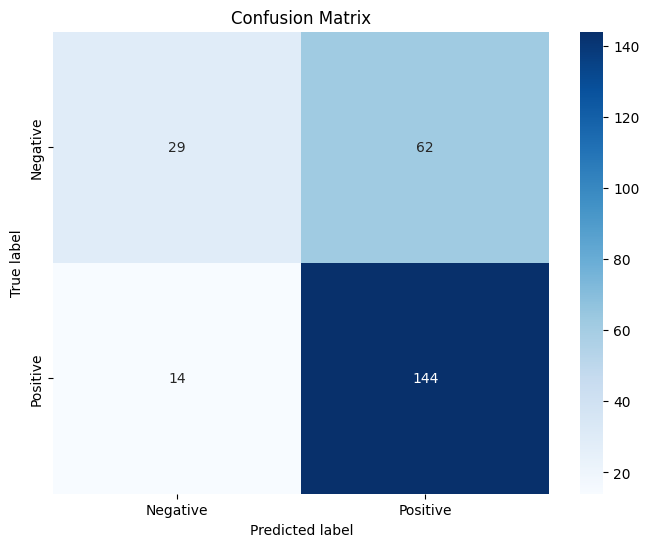

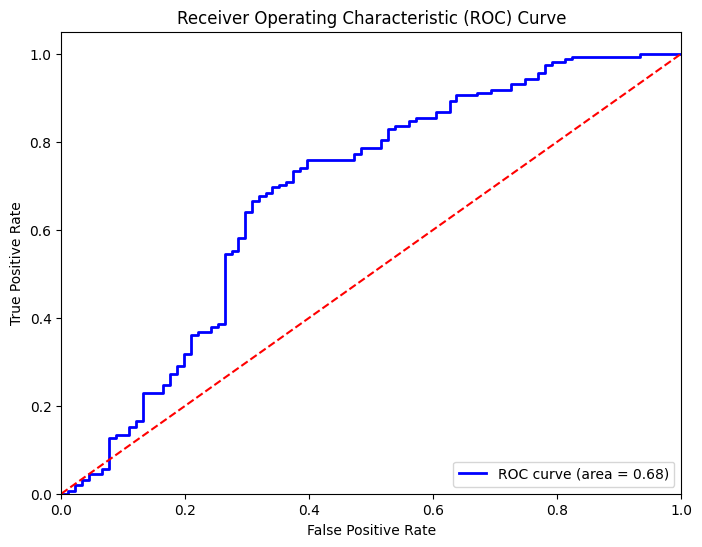

In [13]:
#随机森林搜索参数 时间太长

# 假设 full_df_color 是你已经准备好的数据集
X = full_df_color.drop(columns='Label')
y = full_df_color['Label']

# 定义参数网格
param_grid = {
    'n_estimators': [100, 200, 300],   #400已测试过效果不好
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None]
}

# 创建随机森林模型
model = RandomForestClassifier(random_state=42)

# 使用 GridSearchCV 进行参数优化，设置 verbose=2 以显示进程信息
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

# 输出最佳参数
print("Best Parameters:", grid_search.best_params_)

# 使用最佳参数重新训练模型
best_model = grid_search.best_estimator_

# 五折交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 存储指标
accuracies = []
precisions = []
recalls = []
f1s = []
roc_aucs = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    print(f"Training Fold {fold}...")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    # 计算指标
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

# 计算平均指标
print("Accuracy: ", np.mean(accuracies))
print("Precision: ", np.mean(precisions))
print("Recall: ", np.mean(recalls))
print("F1 Score: ", np.mean(f1s))
print("ROC AUC: ", np.mean(roc_aucs))

# 存储最终的真实值和预测值
y_true = []
y_pred = []
y_prob = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    print(f"Evaluating Fold {fold}...")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_model.fit(X_train, y_train)
    y_pred_fold = best_model.predict(X_test)
    y_prob_fold = best_model.predict_proba(X_test)[:, 1]

    y_true.extend(y_test)
    y_pred.extend(y_pred_fold)
    y_prob.extend(y_prob_fold)

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Accuracy:  0.6409638554216868
Precision:  0.6397781025521108
Recall:  0.9936708860759493
F1 Score:  0.7783827099022236
ROC AUC:  0.5441368757824454


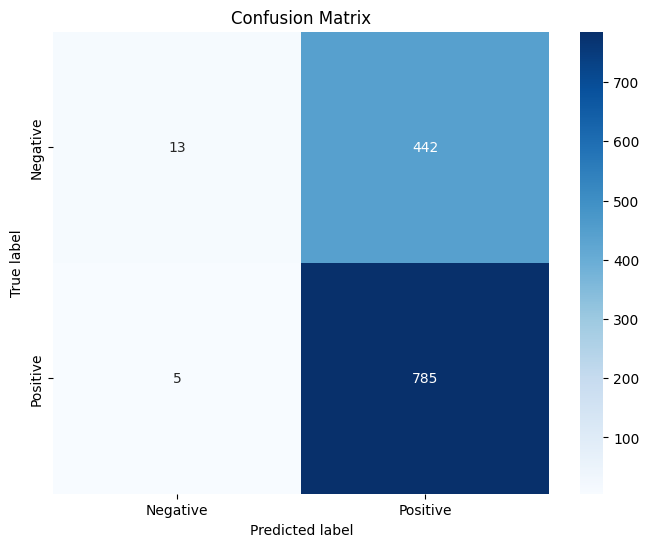

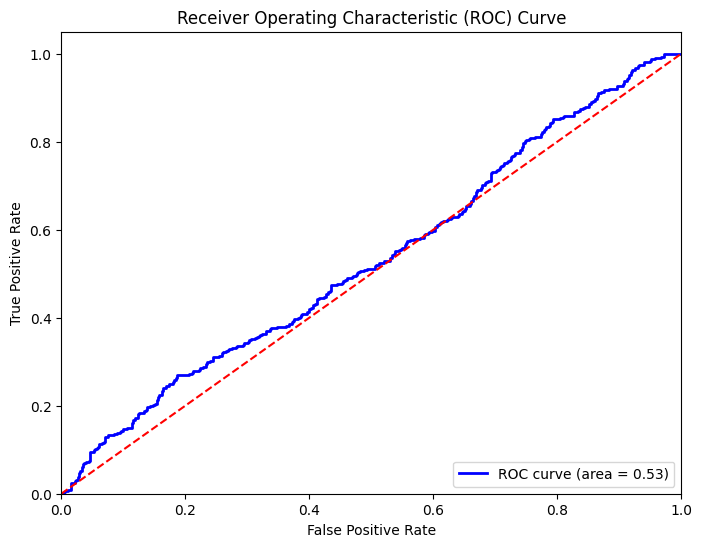

In [288]:
#逻辑回归模型

# 假设 full_df_color 是你已经准备好的数据集
X = full_df_color.drop(columns='Label')
y = full_df_color['Label']

# 五折交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression(
    C=100,
    max_iter=100,
    penalty='l1',
    solver='liblinear',
    random_state=42
)

# 存储指标
accuracies = []
precisions = []
recalls = []
f1s = []
roc_aucs = []

# 存储最终的真实值和预测值
y_true = []
y_pred = []
y_prob = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred_fold = model.predict(X_test)
    y_prob_fold = model.predict_proba(X_test)[:, 1]

    # 计算指标
    accuracies.append(accuracy_score(y_test, y_pred_fold))
    precisions.append(precision_score(y_test, y_pred_fold))
    recalls.append(recall_score(y_test, y_pred_fold))
    f1s.append(f1_score(y_test, y_pred_fold))
    roc_aucs.append(roc_auc_score(y_test, y_prob_fold))

    # 存储真实值和预测值
    y_true.extend(y_test)
    y_pred.extend(y_pred_fold)
    y_prob.extend(y_prob_fold)

# 计算平均指标
print("Accuracy: ", np.mean(accuracies))
print("Precision: ", np.mean(precisions))
print("Recall: ", np.mean(recalls))
print("F1 Score: ", np.mean(f1s))
print("ROC AUC: ", np.mean(roc_aucs))

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [287]:
#逻辑回归 查最优参数
# 假设 full_df_color 是你已经准备好的数据集
X = full_df_color.drop(columns='Label')
y = full_df_color['Label']

# 定义参数网格
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}

# 创建逻辑回归模型
model = LogisticRegression(random_state=42)

# 创建网格搜索对象，设置 verbose=2
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# 拟合数据以查找最佳参数
grid_search.fit(X, y)

# 查看最优参数和得分
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# 使用最优参数训练模型（如果需要）
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'C': 100, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.6409638554216868


Accuracy:  0.6489959839357431
Precision:  0.664037912108752
Recall:  0.9050632911392406
F1 Score:  0.7655320096762672
ROC AUC:  0.5908540826262345


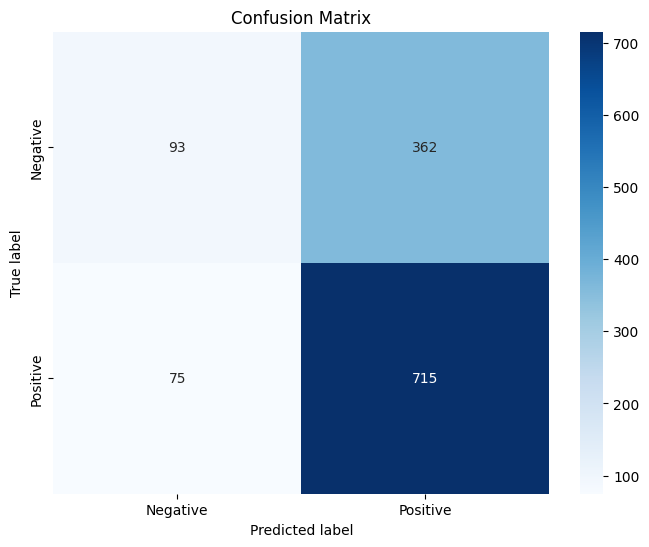

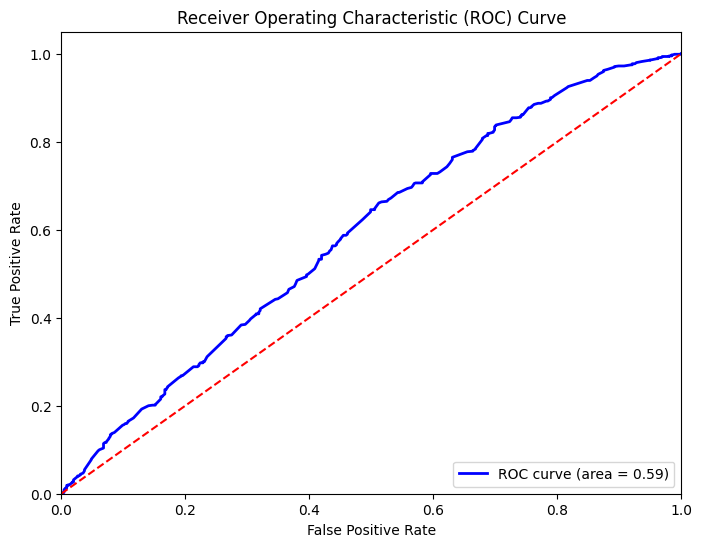

In [292]:
#AdaBoost 模型

# 假设 full_df_color 是你已经准备好的数据集
X = full_df_color.drop(columns='Label')
y = full_df_color['Label']

# 五折交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),
    learning_rate=1,
    n_estimators=50,
    algorithm='SAMME',  # 使用 SAMME 算法
    random_state=42
)

# 存储指标
accuracies = []
precisions = []
recalls = []
f1s = []
roc_aucs = []

# 存储最终的真实值和预测值
y_true = []
y_pred = []
y_prob = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred_fold = model.predict(X_test)
    y_prob_fold = model.predict_proba(X_test)[:, 1]

    # 计算指标
    accuracies.append(accuracy_score(y_test, y_pred_fold))
    precisions.append(precision_score(y_test, y_pred_fold))
    recalls.append(recall_score(y_test, y_pred_fold))
    f1s.append(f1_score(y_test, y_pred_fold))
    roc_aucs.append(roc_auc_score(y_test, y_prob_fold))

    # 存储真实值和预测值
    y_true.extend(y_test)
    y_pred.extend(y_pred_fold)
    y_prob.extend(y_prob_fold)

# 计算平均指标
print("Accuracy: ", np.mean(accuracies))
print("Precision: ", np.mean(precisions))
print("Recall: ", np.mean(recalls))
print("F1 Score: ", np.mean(f1s))
print("ROC AUC: ", np.mean(roc_aucs))

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [291]:
#AdaBoost搜索参数
# 假设 full_df_color 是你已经准备好的数据集
X = full_df_color.drop(columns='Label')
y = full_df_color['Label']

# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}

# 创建模型
model = AdaBoostClassifier(algorithm='SAMME', random_state=42)

# 创建 GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)

# 进行参数搜索
grid_search.fit(X, y)

# 输出最佳参数
print("Best Parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters:  {'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 1, 'n_estimators': 50}


Accuracy:  0.6907630522088353
Precision:  0.7341455231239209
Recall:  0.8037974683544304
F1 Score:  0.7672301348545147
ROC AUC:  0.7007024620948673


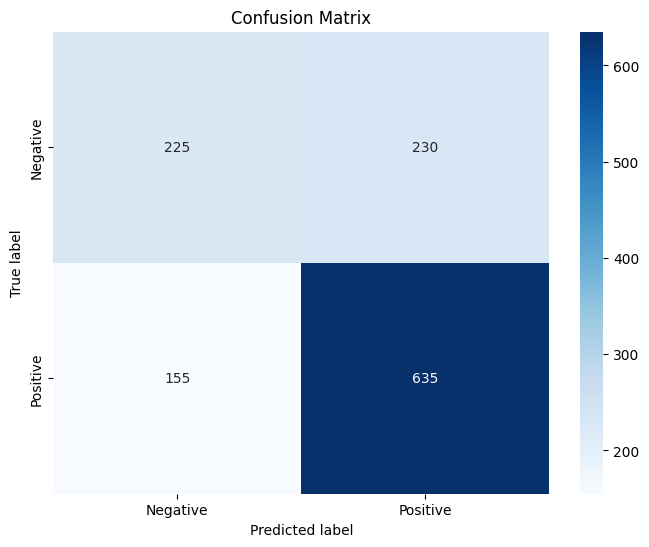

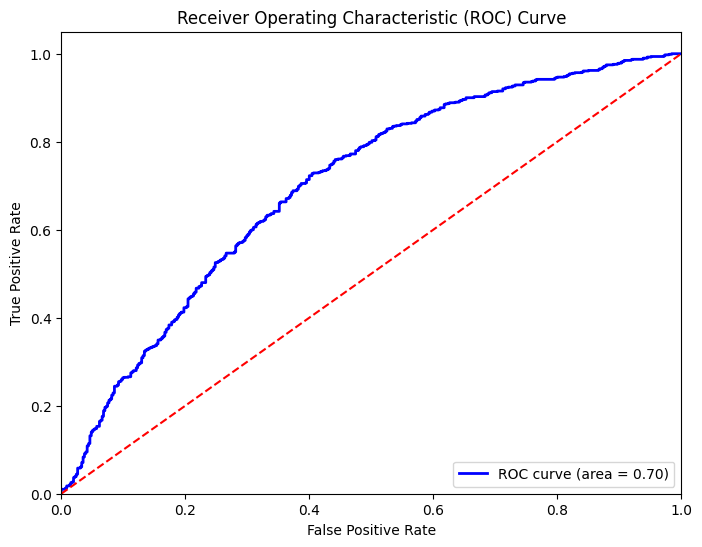

In [294]:
#梯度提升分类器

# 假设 full_df_color 是你已经准备好的数据集
X = full_df_color.drop(columns='Label')
y = full_df_color['Label']

# 五折交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = GradientBoostingClassifier(
    learning_rate=0.2,
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=150,
    random_state=42
)

# 存储指标
accuracies = []
precisions = []
recalls = []
f1s = []
roc_aucs = []

# 存储最终的真实值和预测值
y_true = []
y_pred = []
y_prob = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred_fold = model.predict(X_test)
    y_prob_fold = model.predict_proba(X_test)[:, 1]

    # 计算指标
    accuracies.append(accuracy_score(y_test, y_pred_fold))
    precisions.append(precision_score(y_test, y_pred_fold))
    recalls.append(recall_score(y_test, y_pred_fold))
    f1s.append(f1_score(y_test, y_pred_fold))
    roc_aucs.append(roc_auc_score(y_test, y_prob_fold))

    # 存储真实值和预测值
    y_true.extend(y_test)
    y_pred.extend(y_pred_fold)
    y_prob.extend(y_prob_fold)

# 计算平均指标
print("Accuracy: ", np.mean(accuracies))
print("Precision: ", np.mean(precisions))
print("Recall: ", np.mean(recalls))
print("F1 Score: ", np.mean(f1s))
print("ROC AUC: ", np.mean(roc_aucs))

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [293]:
#梯度提升分类器 参数
# 假设 full_df_color 是你已经准备好的数据集
X = full_df_color.drop(columns='Label')
y = full_df_color['Label']

# 定义模型
model = GradientBoostingClassifier(random_state=42)

# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 使用 GridSearchCV 查找最优参数
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=2)
grid_search.fit(X, y)

# 打印最优参数
print("Best Parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; t

[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4,

[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, m

[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, min_samples

[CV] END learning_rate=0.1, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=4, min_sam

[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, min_sample

[CV] END learning_rate=0.2, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_samples_

[CV] END learning_rate=0.2, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.2, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.6s
[CV] END learning_rate=0.2, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.7s
[CV] END learning_rate=0.2, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.6s
[CV] END learning_rate=0.2, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.6s
[CV] END learning_rate=0.2, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.7s
[CV] END learning_rate=0.2, max_depth=5, min_sam

Accuracy:  0.5534136546184738
Precision:  0.6249653158086892
Recall:  0.7075949367088608
F1 Score:  0.586313077313712
ROC AUC:  0.4971623313395466


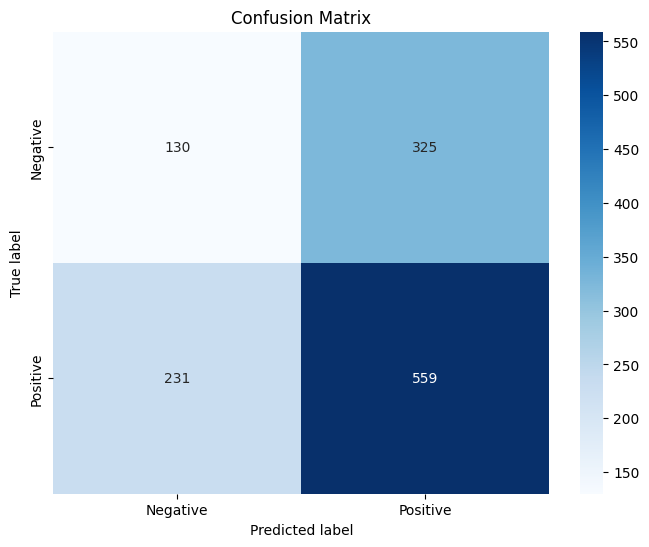

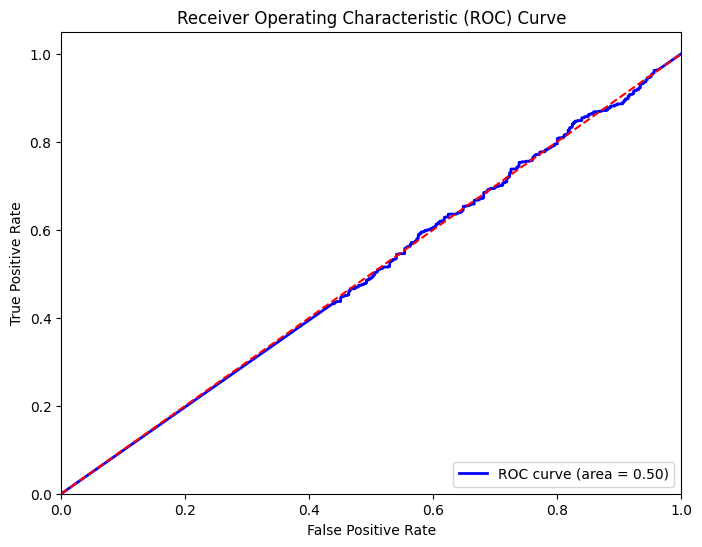

In [268]:
#MLP

# 假设 full_df_color 是你已经准备好的数据集
X = full_df_color.drop(columns='Label')
y = full_df_color['Label']

# 五折交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = MLPClassifier(random_state=42, max_iter=500)

# 存储指标
accuracies = []
precisions = []
recalls = []
f1s = []
roc_aucs = []

# 存储最终的真实值和预测值
y_true = []
y_pred = []
y_prob = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred_fold = model.predict(X_test)
    y_prob_fold = model.predict_proba(X_test)[:, 1]

    # 计算指标
    accuracies.append(accuracy_score(y_test, y_pred_fold))
    precisions.append(precision_score(y_test, y_pred_fold))
    recalls.append(recall_score(y_test, y_pred_fold))
    f1s.append(f1_score(y_test, y_pred_fold))
    roc_aucs.append(roc_auc_score(y_test, y_prob_fold))

    # 存储真实值和预测值
    y_true.extend(y_test)
    y_pred.extend(y_pred_fold)
    y_prob.extend(y_prob_fold)

# 计算平均指标
print("Accuracy: ", np.mean(accuracies))
print("Precision: ", np.mean(precisions))
print("Recall: ", np.mean(recalls))
print("F1 Score: ", np.mean(f1s))
print("ROC AUC: ", np.mean(roc_aucs))

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# 处理过程中的一些其他代码

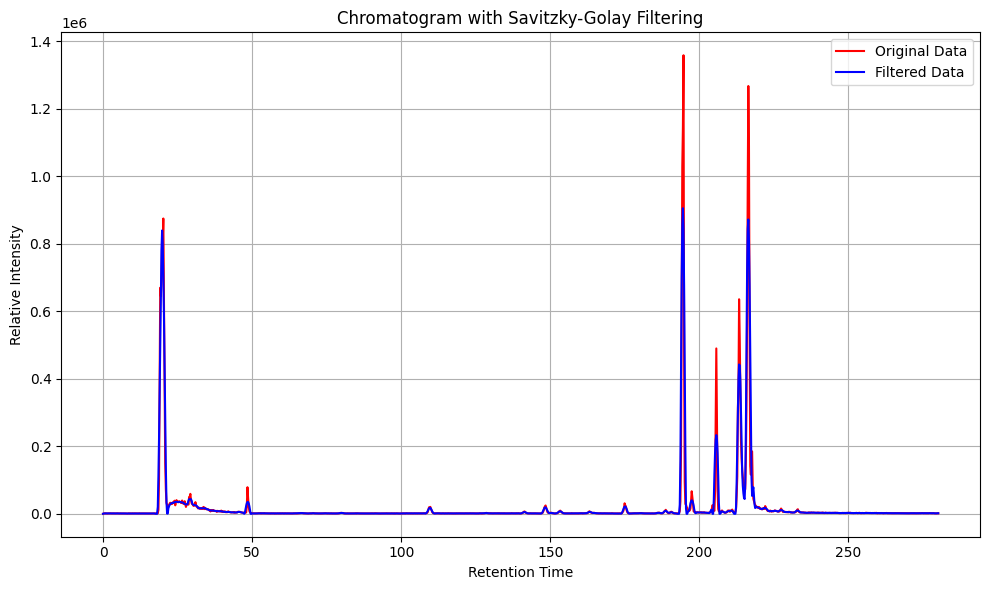

In [195]:
## 单张图展示 看一下滤波效果 （SG滤波）   略有效果
# 假设你要处理的 DataFrame 是 P_data 中的第一个 DataFrame
df = P_data[5]  # 选择第一个 DataFrame

# 计算每一行第三列至倒数第二列的数值之和
y_values = df.iloc[:, 2:-1].sum(axis=1)  # 取第三列到倒数第二列的和
x_values = df.iloc[:, 1]  # 第二列为横坐标

# 应用 Savitzky-Golay 滤波
window_length = 11  # 窗口长度，必须为奇数
polyorder = 3      # 多项式阶数
filtered_y_values = savgol_filter(y_values, window_length, polyorder)
# 处理负值，将负值替换为 0
filtered_y_values = np.where(filtered_y_values < 0, 0, filtered_y_values)

# 针对特定区域（25到40）进行更强平滑滤波
specific_region = (x_values >= 25) & (x_values <= 45)

# 应用中值滤波，窗口大小可以根据需要调整
filtered_y_values[specific_region] = medfilt(filtered_y_values[specific_region], kernel_size=7)


# 绘制原始数据和滤波后的数据
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, linestyle='-', color='r', label='Original Data')  # 原始数据
plt.plot(x_values, filtered_y_values, color='b', label='Filtered Data')  # 滤波后的数据
plt.title('Chromatogram with Savitzky-Golay Filtering')
plt.xlabel('Retention Time')
plt.ylabel('Relative Intensity')
plt.legend()
plt.grid()
plt.tight_layout()  # 自动调整布局
plt.show()


In [204]:
#保存一下SG滤波后的图片
#创建存储图像的文件夹
output_folder = 'filtered_chromatograms'
os.makedirs(output_folder, exist_ok=True)

# 循环遍历每个 DataFrame，使用 tqdm 显示进度
for i, df in enumerate(tqdm(N_data, desc="Processing Chromatograms")):
    # 计算每一行第三列至倒数第二列的数值之和
    y_values = df.iloc[:, 2:-1].sum(axis=1)  # 取第三列到倒数第二列的和
    x_values = df.iloc[:, 1]  # 第二列为横坐标

    # 应用 Savitzky-Golay 滤波
    window_length = 11  # 窗口长度，必须为奇数
    polyorder = 3      # 多项式阶数
    filtered_y_values = savgol_filter(y_values, window_length, polyorder)
    
    # 处理负值，将负值替换为 0
    filtered_y_values = np.where(filtered_y_values < 0, 0, filtered_y_values)

    # 针对特定区域（25到40）进行更强平滑滤波
    specific_region = (x_values >= 25) & (x_values <= 45)
    
    # 应用中值滤波，窗口大小可以根据需要调整
    filtered_y_values[specific_region] = medfilt(filtered_y_values[specific_region], kernel_size=7)

    # 绘制原始数据和滤波后的数据
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values, linestyle='-', color='r', label='Original Data')  # 原始数据
    plt.plot(x_values, filtered_y_values, color='b', label='Filtered Data')  # 滤波后的数据
    plt.title(f'N Chromatogram {i+1} with Savitzky-Golay Filtering')
    plt.xlabel('Retention Time')
    plt.ylabel('Relative Intensity')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # 自动调整布局

    # 保存图像
    plt.savefig(os.path.join(output_folder, f'N_chromatogram_{i+1}.png'))
    plt.close()  # 关闭当前图形以节省内存


Processing Chromatograms: 100%|██████████████████████████████████████████████████████| 104/104 [00:23<00:00,  4.33it/s]


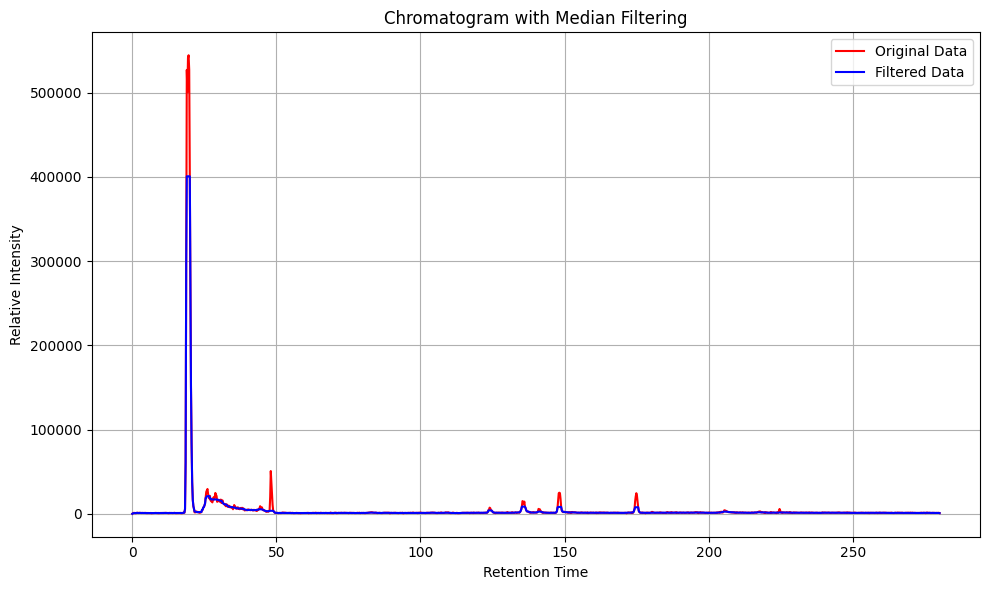

In [42]:
#中值滤波
df = P_data[10]  # 选择第一个 DataFrame

# 计算每一行第三列至倒数第二列的数值之和
y_values = df.iloc[:, 2:-1].sum(axis=1)  # 取第三列到倒数第二列的和
x_values = df.iloc[:, 1]  # 第二列为横坐标

# 应用中值滤波
kernel_size = 11  # 窗口大小，必须为奇数
filtered_y_values = medfilt(y_values, kernel_size)

# 处理负值，将负值替换为 0
filtered_y_values = np.where(filtered_y_values < 0, 0, filtered_y_values)

# 绘制原始数据和滤波后的数据
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, linestyle='-', color='r', label='Original Data')  # 原始数据
plt.plot(x_values, filtered_y_values, color='b', label='Filtered Data')  # 滤波后的数据
plt.title('Chromatogram with Median Filtering')
plt.xlabel('Retention Time')
plt.ylabel('Relative Intensity')
plt.legend()
plt.grid()
plt.tight_layout()  # 自动调整布局
plt.show()

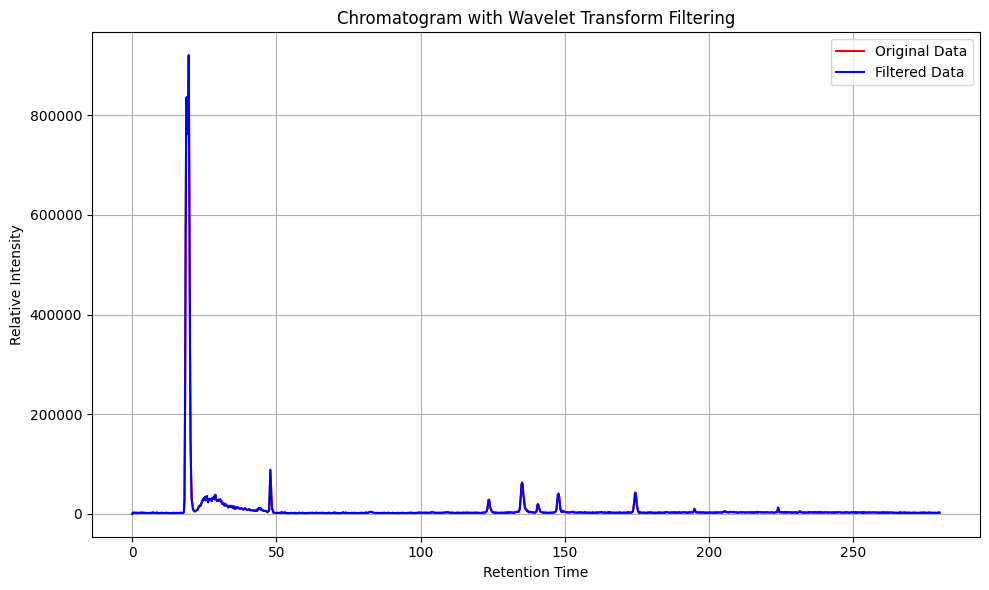

In [67]:
## 单张图展示 看一下滤波效果 （小波变换）   没什么效果
# 假设你要处理的 DataFrame 是 P_data 中的第一个 DataFrame
df = N_data[0]  # 选择第一个 DataFrame

# 计算每一行第三列至倒数第二列的数值之和
y_values = df.iloc[:, 2:-1].sum(axis=1)  # 取第三列到倒数第二列的和
x_values = df.iloc[:, 1]  # 第二列为横坐标

# 进行小波变换（这里使用离散小波变换，选择 Daubechies 小波）
wavelet = 'db5'  # 可以根据需要选择不同的小波
coeffs = pywt.wavedec(y_values, wavelet, level=None)

# 重建信号，通常使用低频系数（近似）
filtered_y_values = pywt.waverec(coeffs, wavelet)

# 绘制原始数据和小波变换后的数据
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, linestyle='-', color='r', label='Original Data')  # 原始数据
plt.plot(x_values, filtered_y_values[:len(y_values)], color='b', label='Filtered Data')  # 滤波后的数据
plt.title('Chromatogram with Wavelet Transform Filtering')
plt.xlabel('Retention Time')
plt.ylabel('Relative Intensity')
plt.legend()
plt.grid()
plt.tight_layout()  # 自动调整布局
plt.show()

In [15]:
#测试一下结构
print(P_data_SG[1])
print(P_data_SG[1].iloc[29])

        序号       RT        43         44         45         46         47  \
0        1      0.0   0.00000     0.0000    0.00000   0.000000   0.000000   
1        2     0.22  39.21290   852.7678  226.15010  20.399820   0.396806   
2        3    0.445  32.98053   851.7695  384.43570  12.670040   0.000000   
3        4    0.668  18.98923   851.4994  329.15070  64.880300  69.558840   
4        5    0.902  20.59085   625.2131   73.83051  19.353900  12.861440   
...    ...      ...       ...        ...        ...        ...        ...   
1261  1262  279.165  82.00597   730.8069  146.07310   2.196473   0.000000   
1262  1263  279.394  60.57310  1165.3740  455.28540   9.509923   0.000000   
1263  1264  279.615  32.54717  1213.9050  164.19180  92.127940   1.454978   
1264  1265  279.833  60.73962  1026.7810  443.28510   0.981016   0.000000   
1265  1266  280.061  33.36120  1215.4520  137.68700   6.606821   0.000000   

            48         49         50  ...       292       293  294       29

In [17]:
print(P_df_color)

     Retention Time    Peak Height  Peak Width     Peak Area  Label
0            20.075  770750.176326    7.236344  5.577413e+06      1
1            48.795   55665.395512    6.106331  3.399113e+05      1
2           148.387   42521.431288    6.335777  2.694063e+05      1
3           175.120   37187.853526    6.307302  2.345550e+05      1
4            29.783   33895.617559   44.234191  1.499345e+06      1
..              ...            ...         ...           ...    ...
830          18.719  715692.164057    7.606451  5.443877e+06      1
831         165.468   65453.751538    6.457382  4.226599e+05      1
832         140.322   46661.426461    6.438897  3.004481e+05      1
833          47.407   25161.054154    6.056598  1.523904e+05      1
834          29.436   23002.795406    9.092951  2.091633e+05      1

[835 rows x 5 columns]


In [19]:
print(P_data)

[        序号       RT         43         44        45          46        47  \
0        1    0.001    0.00000     0.0000    0.0000    0.000000  0.000000   
1        2    0.215  179.89340  1322.3470  412.6178   98.899060  6.419558   
2        3    0.443   71.65234  1211.1900  470.0668    2.087405  0.000000   
3        4    0.662   39.85465  1428.6460  214.0183   21.819820  0.000000   
4        5    0.879   10.22018  1212.0300  385.9669  110.613000  0.638362   
...    ...      ...        ...        ...       ...         ...       ...   
1278  1279  279.357   95.82559  1364.5970  332.3203    1.558144  8.892928   
1279  1280  279.578   65.40943   899.8881  355.3762   33.986970  0.000000   
1280  1281  279.795   73.03775  1253.8890  289.2629    1.025576  0.000000   
1281  1282  280.024   36.50655  1336.8280  363.0568    4.505296  0.000000   
1282  1283   280.24   55.25437  1223.4000  368.7414   17.037910  0.000000   

            48         49         50  ...      291       292       293  \


In [180]:
print(P_data_feature)

[   Retention Time    Peak Height  Peak Width      Peak Area
0          20.075  770750.176326    7.236344  900097.359591
1          48.795   55665.395512    6.106331   57450.877134
4         135.894   33148.445208    6.932953   39612.223492
2         148.387   42521.431288    6.335777   48720.714958
3         175.120   37187.853526    6.307302   38986.950929,    Retention Time    Peak Height  Peak Width      Peak Area
0          19.874  373339.122039    6.798953  387416.585680
3          48.896   22062.480490    6.164784   22412.541595
4         135.958   21541.740375    7.020894   26619.589228
1         148.405   36056.205424    6.321971   40872.847450
2         175.012   32908.653334    6.256094   34499.344462,    Retention Time   Peak Height  Peak Width     Peak Area
3          19.948  6.391204e+05    7.375789  7.633173e+05
0         195.040  3.398523e+06    6.436759  3.487201e+06
4         197.745  3.314088e+05    5.952658  3.155817e+05
2         213.610  1.867284e+06    6.745657  

In [233]:
print(N_data_feature[0])

   Retention Time    Peak Height  Peak Width     Peak Area
0          19.167  886929.679346    7.098149  1.034357e+06
2          47.907   45880.260572    6.078260  4.695621e+04
1         135.233   52906.144860    6.734341  6.115174e+04
4         147.875   32757.390690    6.227485  3.374567e+04
3         174.618   33137.149015    6.244652  3.444230e+04


In [239]:
print(normalized_N_data_feature) 

[   Retention Time  Peak Height  Peak Width     Peak Area
0          19.167     0.764655    7.098149  1.034357e+06
2          47.907     0.013008    6.078260  4.695621e+04
1         135.233     0.088082    6.734341  6.115174e+04
4         147.875     0.018773    6.227485  3.374567e+04
3         174.618     0.019753    6.244652  3.444230e+04,    Retention Time  Peak Height  Peak Width      Peak Area
0          19.886     0.666054    7.624885  990699.015624
2          48.687     0.014333    6.070694   51426.260241
1         135.309     0.089711    6.692404   56766.522023
4         147.946     0.016835    6.368107   30486.859668
3         174.514     0.018287    6.225267   34940.920513,    Retention Time  Peak Height  Peak Width     Peak Area
2          19.534     0.702450    7.227180  9.467313e+05
0         194.196     0.342786    5.896014  1.199370e+06
3         213.097     1.000000    6.430122  5.709542e+05
1         216.039     0.692178    6.322846  1.205028e+06
4         217.714     

In [278]:
print(remove_normalized_N_data_feature)

[   Retention Time  Peak Height  Peak Width     Peak Area
0          19.167     0.764655    7.098149  1.034357e+06
2          47.907     0.013008    6.078260  4.695621e+04
1         135.233     0.088082    6.734341  6.115174e+04
4         147.875     0.018773    6.227485  3.374567e+04
3         174.618     0.019753    6.244652  3.444230e+04,    Retention Time  Peak Height  Peak Width      Peak Area
0          19.886     0.666054    7.624885  990699.015624
2          48.687     0.014333    6.070694   51426.260241
1         135.309     0.089711    6.692404   56766.522023
4         147.946     0.016835    6.368107   30486.859668
3         174.514     0.018287    6.225267   34940.920513,    Retention Time  Peak Height  Peak Width     Peak Area
0          19.571     0.673408    7.672189  1.017159e+06
1          48.266     0.009076    6.082393  3.389189e+04
2         135.554     0.040556    6.949279  2.880163e+04
3         148.096     0.011425    6.372131  2.129715e+04
4         174.670     

In [304]:
print(len(remove_normalized_P_data_feature))

158


In [296]:
print(P_df_color)

     Retention Time  Peak Height  Peak Width      Peak Area  Label
0            20.075     0.543850    7.236344  900097.359591      1
1            48.795     0.016187    6.106331   57450.877134      1
2           135.894     0.060114    6.932953   39612.223492      1
3           148.387     0.022422    6.335777   48720.714958      1
4           175.120     0.016400    6.307302   38986.950929      1
..              ...          ...         ...            ...    ...
785          18.719     0.504949    7.606451  805255.874650      1
786          47.407     0.007210    6.056598   24630.380854      1
787         140.322     0.085071    6.438897   44849.704759      1
788         165.468     0.034708    6.457382   59303.570986      1
789         230.226     0.001134    7.963950    4183.701324      1

[790 rows x 5 columns]


In [316]:
print(full_df_color)

[(1,    Retention Time  Peak Height  Peak Width      Peak Area
0          20.075     0.543850    7.236344  900097.359591
1          48.795     0.016187    6.106331   57450.877134
4         135.894     0.060114    6.932953   39612.223492
2         148.387     0.022422    6.335777   48720.714958
3         175.120     0.016400    6.307302   38986.950929), (1,    Retention Time  Peak Height  Peak Width      Peak Area
0          19.874     0.263061    6.798953  387416.585680
3          48.896     0.006298    6.164784   22412.541595
4         135.958     0.038678    7.020894   26619.589228
1         148.405     0.018958    6.321971   40872.847450
2         175.012     0.014484    6.256094   34499.344462), (1,    Retention Time  Peak Height  Peak Width     Peak Area
2          19.810     0.592363    7.682738  1.093670e+06
0         194.520     0.266242    5.852882  7.909733e+05
4         205.729     0.429556    5.982017  2.282542e+05
3         213.370     0.236639    6.369770  4.642489e+05
1 